# Futures

In [3]:
import websockets
import asyncio as aio
import json
from datetime import datetime

In [21]:
url = 'wss://www.deribit.com/ws/api/v2'


async def api(msg):
    async with websockets.connect(url) as ws:
        await ws.send(json.dumps(msg))
        return json.loads(await ws.recv())

async def instruments(currency):
    msg = {
        "jsonrpc": "2.0",
        "method": "public/get_instruments",
        "id": 7617,
        "params": {
            "currency": currency,
            "kind": "future",
            "expired": False,
        }
    }

    return await api(msg)

async def ticker(instrument):
    msg = {
        "jsonrpc": "2.0",
        "method": "public/ticker",
        "id": 7617,
        "params": {
            "instrument_name": instrument,
        }
    }

    return await api(msg)

def ts(dt):
    return int(1000 * dt.timestamp())

In [22]:
instrs = await instruments('BTC')
instrs = {e['instrument_name'] for e in instrs['result']} - {'BTC-PERPETUAL'}
instrs

{'BTC-24SEP21',
 'BTC-25JUN21',
 'BTC-25MAR22',
 'BTC-28MAY21',
 'BTC-30APR21',
 'BTC-31DEC21',
 'BTC-7MAY21'}

In [23]:
prices = {instr: (await ticker(instr))['result']['mark_price'] for instr in instrs}
prices

{'BTC-30APR21': 49658.84,
 'BTC-25MAR22': 58729.4,
 'BTC-28MAY21': 50313.29,
 'BTC-7MAY21': 49906.67,
 'BTC-25JUN21': 51078.74,
 'BTC-31DEC21': 56355.2,
 'BTC-24SEP21': 53631.18}

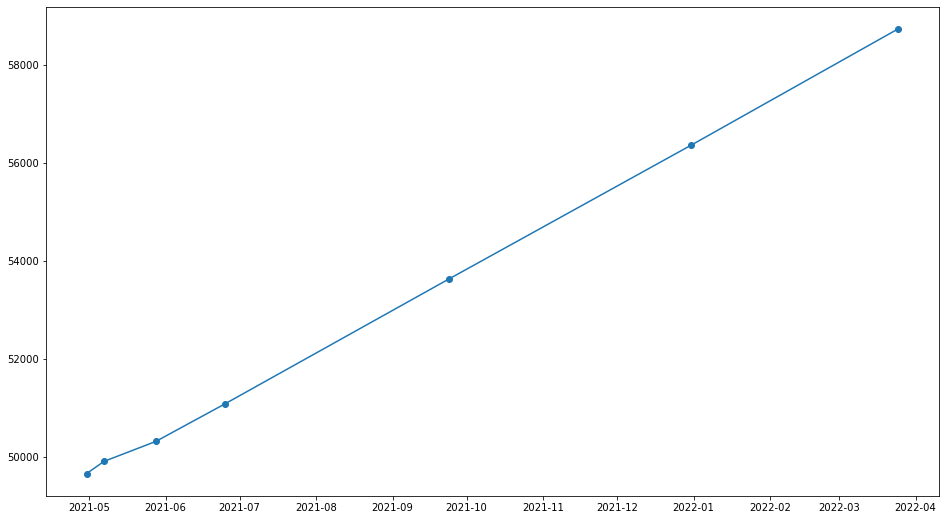

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


dts = pd.to_datetime([instr[4:] for instr in instrs])
ix = dts.argsort()

tks = np.asarray([prices[instr] for instr in instrs])

plt.figure(figsize=(16, 9))
plt.plot(dts[ix], tks[ix], marker='o')

1.2247294432158102

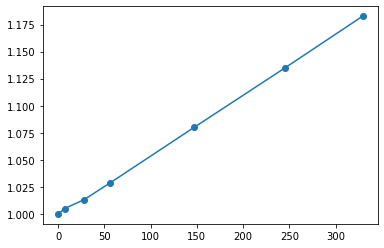

In [25]:
from scipy.stats import linregress


days = dts[ix].astype('int64') / (10 ** 9 * 3600 * 24)
days = days - np.min(days)
returns = tks[ix] / np.min(tks[ix])

plt.plot(days, returns, marker='o')

res = linregress(days, returns)
(1 + res.slope) ** 365